### Feature Selection and Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Load the cleaned dataset
data = pd.read_csv("cleaned_data_after_eda.csv")

In [3]:
# Define the target variable and features
X = data.drop(columns=['GDP_(constant_2015_US$)', 'Country_Name', 'Country_Code', 'Year'])
y = data['GDP_(constant_2015_US$)']

In [4]:
# Feature Selection using SelectKBest
select_k = SelectKBest(score_func=f_regression, k=15)
X_selected = select_k.fit_transform(X, y)
selected_features = X.columns[select_k.get_support()]

In [5]:
selected_features

Index(['Birth_rate_crude_(per_1,000_people)',
       'Fertility_rate_total_(births_per_woman)',
       'GNI_per_capita_Atlas_method_(current_US$)', 'Labor_force_total',
       'Life_expectancy_at_birth_total_(years)',
       'People_using_safely_managed_sanitation_services_(%_of_population)',
       'People_using_safely_managed_sanitation_services_rural_(%_of_rural_population)',
       'People_using_safely_managed_sanitation_services_urban__(%_of_urban_population)',
       'Population_total', 'Rural_population',
       'School_enrollment_secondary_female_(%_gross)',
       'School_enrollment_tertiary_(%_gross)', 'Urban_population',
       'Net_trade_in_goods_and_services(current_$USD)',
       'electricity_demand(in_TWh)'],
      dtype='object')

In [6]:
# Feature Engineering

# Define the features for polynomial transformations
features_to_transform = ['electricity_demand(in_TWh)', 'GNI_per_capita_Atlas_method_(current_US$)', 'Urban_population','Rural_population']

# Apply polynomial transformations
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X[features_to_transform])
poly_features_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(features_to_transform))

# Create interaction terms
interaction_features = X[['electricity_demand(in_TWh)', 'Urban_population', 'Labor_force_total']]
X_interactions = interaction_features.copy()
X_interactions['electricity_Urban'] = interaction_features['electricity_demand(in_TWh)'] * interaction_features['Urban_population']
X_interactions['electricity_Labor'] = interaction_features['electricity_demand(in_TWh)'] * interaction_features['Labor_force_total']

# Apply log transformations for skewed distributions
X_log = X[['Population_total', 'Labor_force_total']].copy()
X_log = X_log.applymap(lambda x: np.log1p(x))  # log(1 + x) to handle zeros

# Combine all engineered features
X_engineered = pd.concat([X[selected_features], poly_features_df, X_interactions, X_log], axis=1)



# Output the shape and first few rows of the engineered feature set
print("Engineered Feature Set Shape:", X_engineered.shape)

Engineered Feature Set Shape: (5336, 36)


### Model Selection and Training

#### Random Forest Regressor

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_engineered, y, test_size=0.2, random_state=42)

# Train and evaluate the Random Forest Regressor with hyperparameter tuning
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Grid search for Random Forest
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf = rf_grid_search.best_estimator_

# Evaluate Random Forest model
rf_predictions = best_rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = rf_mse ** 0.5
rf_r2 = r2_score(y_test, rf_predictions)

rf_results = {
    'Model': 'Random Forest',
    'MAE': rf_mae,
    'MSE': rf_mse,
    'RMSE': rf_rmse,
    'R2': rf_r2,
    'Best Params': rf_grid_search.best_params_
}

print(rf_results)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'Model': 'Random Forest', 'MAE': 0.01172860535875743, 'MSE': 0.0025682619403842154, 'RMSE': 0.05067802226196495, 'R2': 0.9968382166343078, 'Best Params': {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}}


#### XGBoost Regressor

In [8]:
# Ensure y_train and y_test are 1D arrays
y_train = y_train.ravel()
y_test = y_test.ravel()

# Convert X_train and y_train to NumPy arrays explicitly
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Verify the shape of the input data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Train and evaluate the XGBoost Regressor with hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Grid search for XGBoost
xgb_grid_search = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror'), xgb_param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)

# Verify input data shape before fitting
print("Shape of X_train before fitting:", X_train.shape)
print("Shape of y_train before fitting:", y_train.shape)

xgb_grid_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb = xgb_grid_search.best_estimator_

# Evaluate XGBoost model
xgb_predictions = best_xgb.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

xgb_results = {
    'Model': 'XGBoost',
    'MAE': xgb_mae,
    'MSE': xgb_mse,
    'RMSE': xgb_rmse,
    'R2': xgb_r2,
    'Best Params': xgb_grid_search.best_params_
}

print(xgb_results)

X_train shape: (4268, 36)
X_test shape: (1068, 36)
y_train shape: (4268,)
y_test shape: (1068,)
Shape of X_train before fitting: (4268, 36)
Shape of y_train before fitting: (4268,)
Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'Model': 'XGBoost', 'MAE': 0.01809506457635046, 'MSE': 0.0038964833252182344, 'RMSE': 0.062421817701972075, 'R2': 0.9952030453091054, 'Best Params': {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}}


#### Linear Regression

In [9]:
# Train and evaluate the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Evaluate Linear Regression model
linear_predictions = linear_model.predict(X_test)
linear_mae = mean_absolute_error(y_test, linear_predictions)
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_rmse = linear_mse ** 0.5
linear_r2 = r2_score(y_test, linear_predictions)

linear_results = {
    'Model': 'Linear Regression',
    'MAE': linear_mae,
    'MSE': linear_mse,
    'RMSE': linear_rmse,
    'R2': linear_r2
}

print(linear_results)

{'Model': 'Linear Regression', 'MAE': 0.04949031842736062, 'MSE': 0.01204547364438626, 'RMSE': 0.10975187307917009, 'R2': 0.9851708357306393}


#### Support Vector Regression

In [10]:
# Train and evaluate the Support Vector Regression (SVR) model with hyperparameter tuning
svr_param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf']
}

# Grid search for SVR
svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
svr_grid_search.fit(X_train, y_train)

# Best SVR model
best_svr = svr_grid_search.best_estimator_

# Evaluate SVR model
svr_predictions = best_svr.predict(X_test)
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_rmse = svr_mse ** 0.5
svr_r2 = r2_score(y_test, svr_predictions)

svr_results = {
    'Model': 'Support Vector Regression',
    'MAE': svr_mae,
    'MSE': svr_mse,
    'RMSE': svr_rmse,
    'R2': svr_r2,
    'Best Params': svr_grid_search.best_params_
}

print(svr_results)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'Model': 'Support Vector Regression', 'MAE': 0.05909869207127774, 'MSE': 0.01294222521689494, 'RMSE': 0.11376390120286373, 'R2': 0.9840668462346567, 'Best Params': {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}}


#### Gradient Boosting Regressor

In [11]:
# Train and evaluate the Gradient Boosting Regressor with hyperparameter tuning
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Grid search for Gradient Boosting
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
gb_grid_search.fit(X_train, y_train)

# Best Gradient Boosting model
best_gb = gb_grid_search.best_estimator_

# Evaluate Gradient Boosting model
gb_predictions = best_gb.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_rmse = gb_mse ** 0.5
gb_r2 = r2_score(y_test, gb_predictions)

gb_results = {
    'Model': 'Gradient Boosting',
    'MAE': gb_mae,
    'MSE': gb_mse,
    'RMSE': gb_rmse,
    'R2': gb_r2,
    'Best Params': gb_grid_search.best_params_
}

print(gb_results)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'Model': 'Gradient Boosting', 'MAE': 0.01206260996325584, 'MSE': 0.0020978322014397386, 'RMSE': 0.04580209822093021, 'R2': 0.997417361969888, 'Best Params': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}}


C:\Users\Dell\AppData\Local\Temp\ipykernel_6680\2576800274.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')


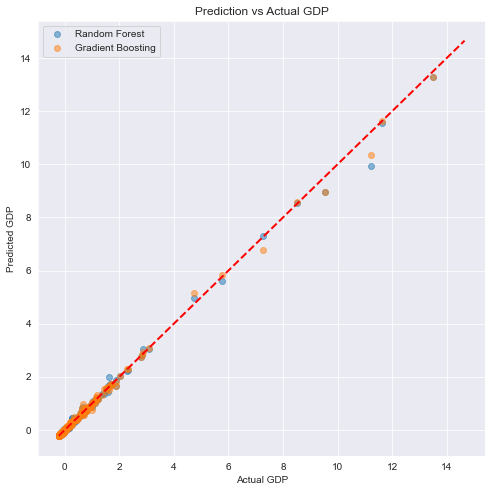

In [12]:
# Prediction vs Actual Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, rf_predictions, alpha=0.5, label='Random Forest')
plt.scatter(y_test, gb_predictions, alpha=0.5, label='Gradient Boosting')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual GDP')
plt.ylabel('Predicted GDP')
plt.title('Prediction vs Actual GDP')
plt.legend()
plt.show()

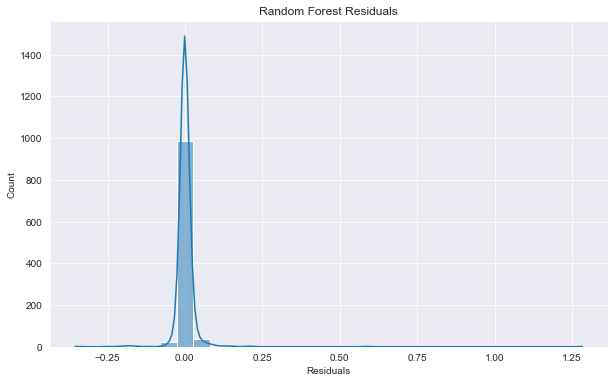

In [13]:
# Residual Plot for Random Forest
rf_residuals = y_test - rf_predictions
plt.figure(figsize=(10, 6))
sns.histplot(rf_residuals, kde=True, bins=30)
plt.title('Random Forest Residuals')
plt.xlabel('Residuals')
plt.show()

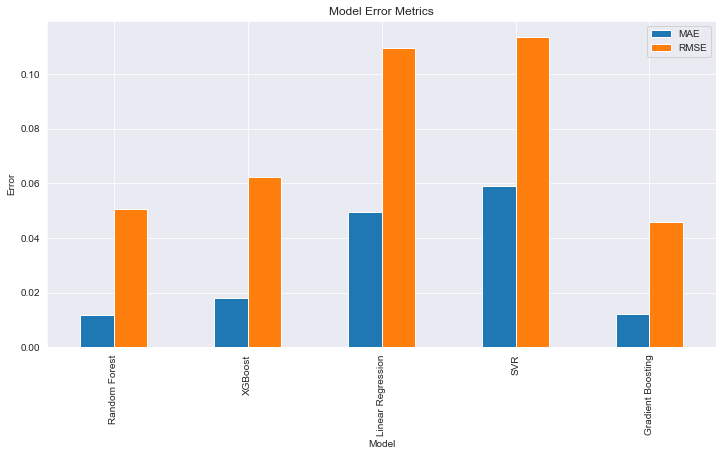

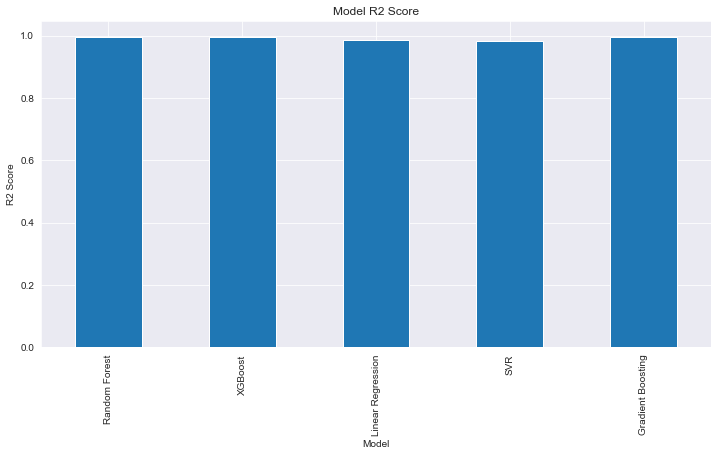

In [14]:
# Error Metrics Bar Chart
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Linear Regression', 'SVR', 'Gradient Boosting'],
    'MAE': [rf_mae, xgb_mae, linear_mae, svr_mae, gb_mae],
    'RMSE': [rf_rmse, xgb_rmse, linear_rmse, svr_rmse, gb_rmse],
    'R2': [rf_r2, xgb_r2, linear_r2, svr_r2, gb_r2]
})
metrics_df.set_index('Model', inplace=True)

metrics_df[['MAE', 'RMSE']].plot(kind='bar', figsize=(12, 6), title='Model Error Metrics')
plt.ylabel('Error')
plt.show()

metrics_df['R2'].plot(kind='bar', figsize=(12, 6), title='Model R2 Score')
plt.ylabel('R2 Score')
plt.show()

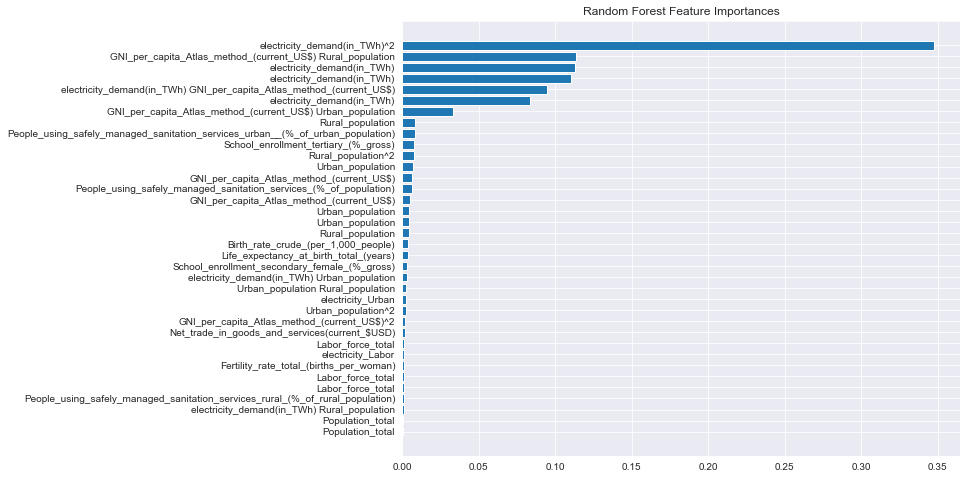

In [15]:
# Feature Importance for Random Forest
rf_importances = best_rf.feature_importances_
sorted_idx = rf_importances.argsort()
plt.figure(figsize=(10, 8))
plt.barh(range(len(rf_importances)), rf_importances[sorted_idx], align='center')
plt.yticks(range(len(rf_importances)), [X_engineered.columns[i] for i in sorted_idx])
plt.title('Random Forest Feature Importances')
plt.show()

In [16]:
import joblib
from feature_engineering_module import feature_engineering
joblib.dump(feature_engineering, 'feature_engineering.pkl')

['feature_engineering.pkl']

In [17]:
# Save the Random Forest model
joblib.dump(best_rf, 'rf_model.pkl')

# Save the Gradient Boosting model
joblib.dump(best_gb, 'gb_model.pkl')

['gb_model.pkl']